# Lotka-volterra

Predator-prey, foxes and rabbits, boom-bust cycles...

## Macroscopic model (population-level)

$$
\frac{dX}{dt} = \alpha X - \beta XY
$$

$$
\frac{dY}{dt} = \beta XY - \mu Y
$$

## Numerical exploration of macroscopic model

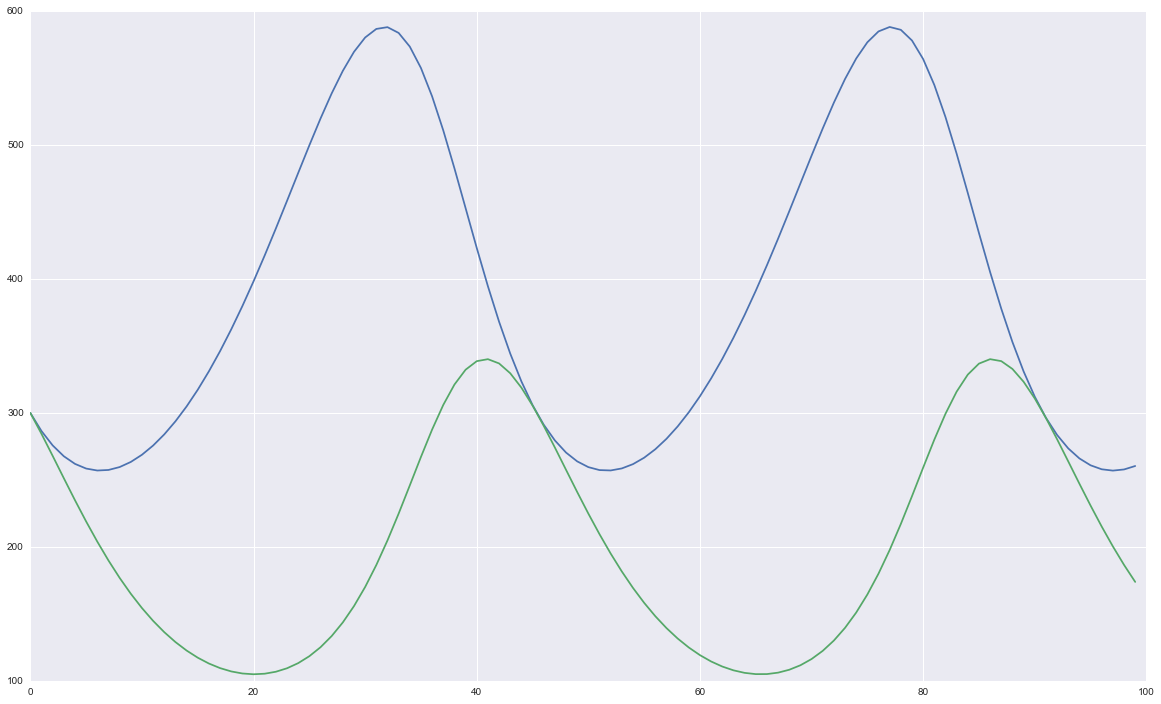

In [3]:
import sympy as sp
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as pl
import seaborn as sb

%matplotlib inline

#Variables
X, Y = sp.symbols("X Y")

#Parameters
a, B, mu = sp.symbols('α β μ')

model = [
    a*X - B*X*Y, #Prey
    B*X*Y - mu*Y #Predator
]

parm = {a:0.1, B: 0.0005, mu: 0.2}

system = map(lambda eq: eq.subs(parm), model)

fn = generate_derivative_fn([X,Y],system)
t = np.arange(0, 100, 1)
y = odeint(fn, [300,300], t, hmax=0.01)

fig, ax = pl.subplots(figsize=(20,12))
_ = pl.plot(t, y)

## Microscopic modelling (individual-level)

Map ODE into transitions

$$
T(x,y \vert x+1,y) = \alpha X
$$

$$
T(x,y \vert x-1,y+1) = \beta XY
$$

$$
T(x,y \vert x,y-1) = \mu Y
$$


Transitions comprise a stochiometic matrix $\bf{S}$ and propensity vector $\bf{p}$.

$$
\bf{S} = 
\left( \begin{array}{cc}
1 & 0 \\
-1 & 1 \\
0 & -1 \end{array} \right)
$$

$$
\bf{p} = \left( \begin{array}{c} \alpha X & \beta X Y & \mu Y \end{array} \right)
$$



In [4]:
import numpy as np
import seaborn as sb
import theano.tensor as tt
import matplotlib.pyplot as pl
import gillespie.vec as gv


X, Y = map(tt.dvector, "XY")
a, B, mu = map(tt.dscalar, ["a","β","μ"])
P = [a*X, B*X*Y, mu*Y]
S = [
    [ 1, 0],
    [-1, 1],
    [ 0,-1]
]

fn = gv.function([X, Y], [a, B, mu], P, S)


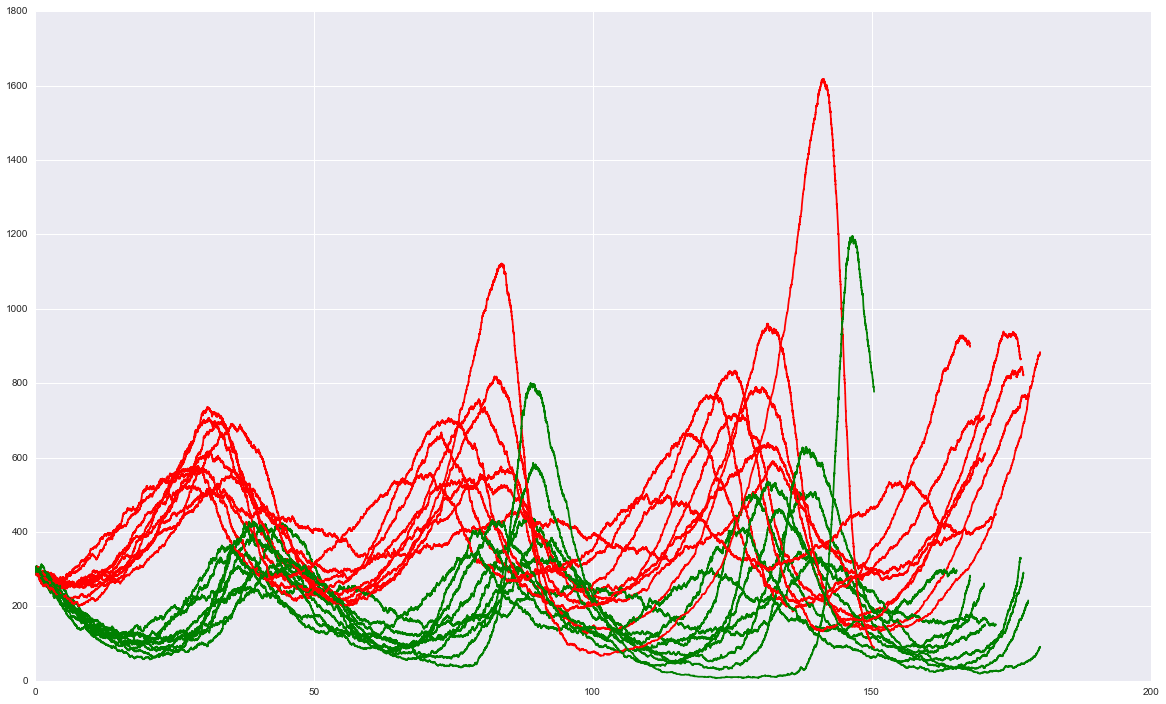

In [104]:
r = 10
intervals = 20000
out = fn([np.asarray([300]*r), np.asarray([300]*r)], [0.1, 0.0005, 0.2], intervals)

fig = pl.figure(figsize=(20,12))
for q in range(r):
    pl.plot(out[q,:,0:1], out[q,:,1], "r-", out[q,:,0:1], out[q,:,2], "g-")

In [2]:
def generate_derivative_fn(var, model):
    """ returns a lambda function similar to
    def f(x, t):
        states = [(S,x[0])]+map(lambda tau: (Q[tau], x[tau+1]), tau)+[(N, x[tau_max+1])]+[(m_t, m(t))]
        return map(lambda s_i: s_i.subs(states), system)
    """
    var_s = map(str, var)
    state_s = map(lambda i: "x[%s]" % i, range(len(var)))
    mapping = dict(zip(var_s, state_s))
    f_str = """lambda x, t: %s""" % reduce(lambda x, y: x.replace(y, mapping[y]), mapping.keys(), str(model))
    return eval(f_str)

In [107]:
import numpy as np

def discretize_time(simulation_data):
    reps, itr, var = simulation_data.shape

    #minimum replicate time
    tmax = int(simulation_data[:,itr-1,0].min())
    ts = np.linspace(0,tmax,tmax*2+1)

    result = np.zeros((reps, len(ts), var))

    for r in range(reps):
        i = 0
        point = simulation_data[r,0,:] #simulation isn't returning correct ics
    
        for ti, t in enumerate(ts):

            while i < itr:
            
                point_ = simulation_data[r,i,:]
            
                if point_[0] > t:
                    point[0] = t
                    result[r, ti] = point
                    point = point_
                    break
            
                point = point_
                i+=1
    
    return result


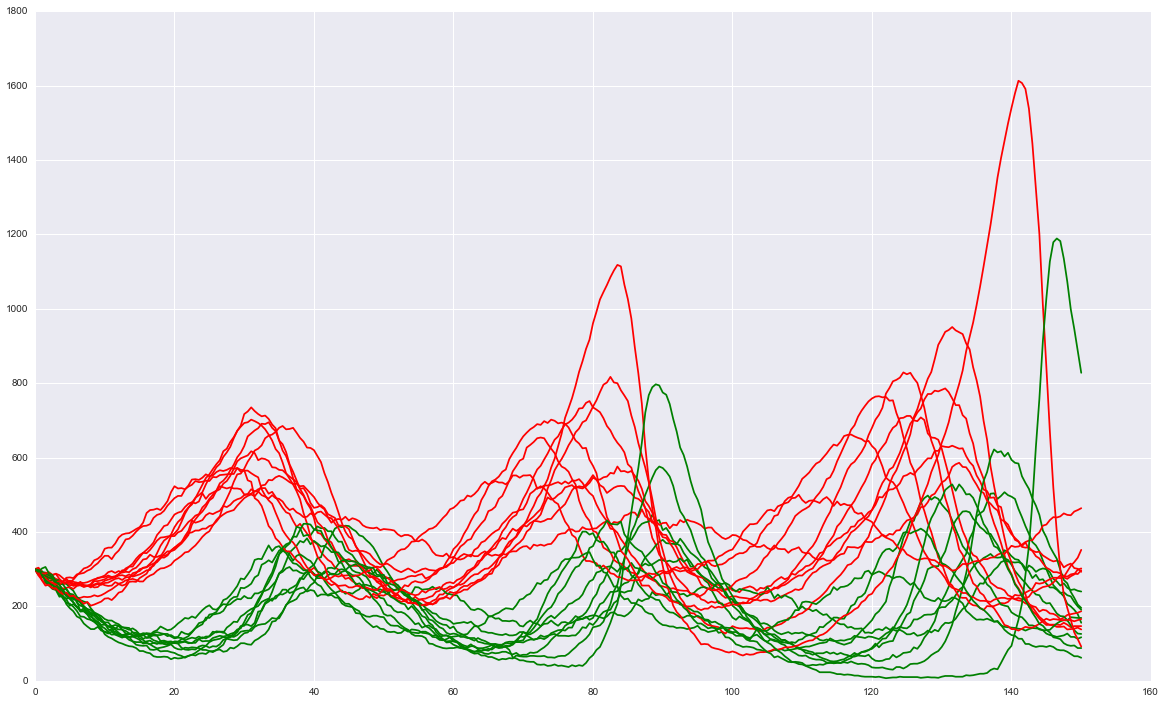

In [108]:
data = discretize_time(out)

fig = pl.figure(figsize=(20,12))
for q in range(reps):
    pl.plot(data[q,:,0:1], data[q,:,1], "r-", data[q,:,0:1], data[q,:,2], "g-")

In [61]:
data.shape


(10, 243, 3)

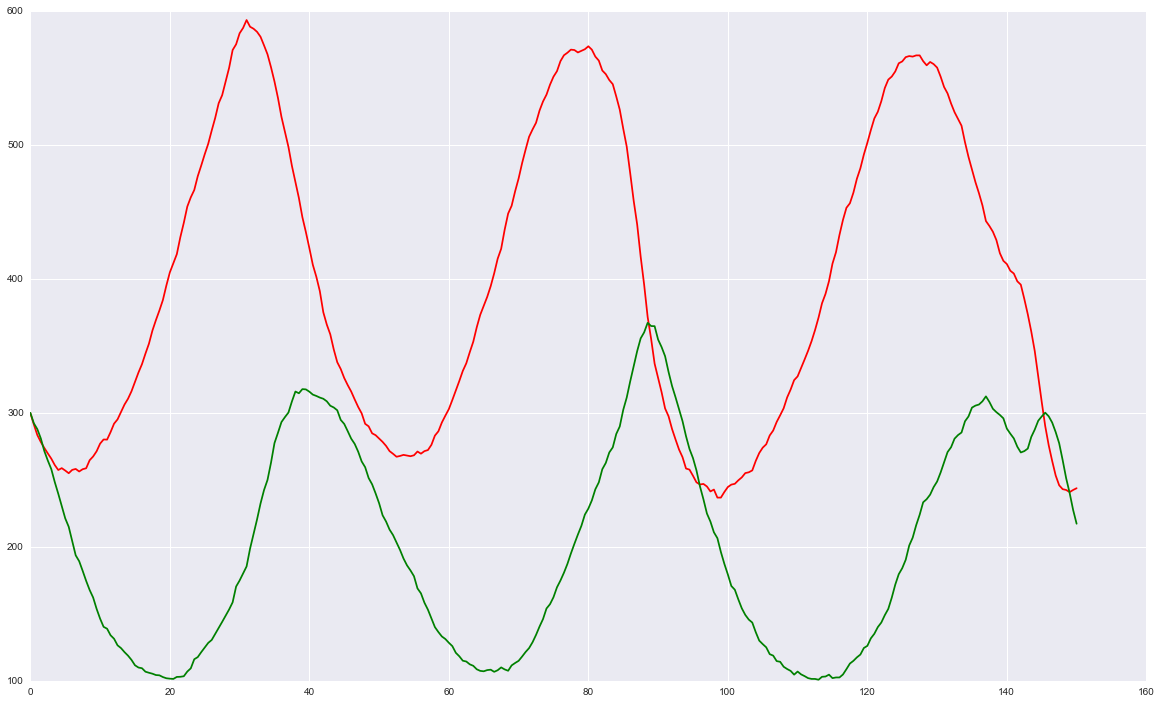

In [109]:
t = data[0,:,0]

mu = data[:,:,1:].mean(axis=0)

fig = pl.figure(figsize=(20,12))
pl.plot(t, mu[:,0], "r-", t, mu[:,1], "g-")